### Environment and Device Check  
Before training the model, it is important to verify that TensorFlow is installed correctly and to identify which devices are available for computation.  
This cell prints the TensorFlow version, lists all logical devices detected by TensorFlow, and reports the number of GPUs available.  
This determines whether training will run on CPU or GPU.


In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Available devices:")
for d in tf.config.list_logical_devices():
    print(" ", d)

print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.19.0
Available devices:
  LogicalDevice(name='/device:CPU:0', device_type='CPU')
  LogicalDevice(name='/device:GPU:0', device_type='GPU')
Num GPUs: 1


### Install kagglehub  
This project uses Tiny-ImageNet downloaded through **kagglehub**, so we need to install the package before accessing the dataset.  
This cell installs kagglehub inside the current environment.


In [2]:
!pip install kagglehub


### Download Tiny-ImageNet  
We use `kagglehub` to download the Tiny-ImageNet dataset.  
This block retrieves the dataset, prints the local path, and sets the project root directory so later cells can load images correctly.


In [3]:
import kagglehub, os

# Download using KaggleHub (cached on Colab)
src = kagglehub.dataset_download("akash2sharma/tiny-imagenet")

print("KaggleHub source:", src)
print("Top-level contents:", os.listdir(src))

# This is the correct dataset root
root = os.path.join(src, "tiny-imagenet-200")
print("ROOT =", root)

# Show contents
print("Root contents:", os.listdir(root))

Using Colab cache for faster access to the 'tiny-imagenet' dataset.
KaggleHub source: /kaggle/input/tiny-imagenet
Top-level contents: ['tiny-imagenet-200']
ROOT = /kaggle/input/tiny-imagenet/tiny-imagenet-200
Root contents: ['words.txt', 'wnids.txt', 'tiny-imagenet-200', 'val', 'test', 'train']


In [4]:
import subprocess

print("=== Train class count ===")
out = subprocess.check_output(
    f"find /kaggle/input/tiny-imagenet/tiny-imagenet-200/train -maxdepth 1 -type d | wc -l",
    shell=True
)
print(out.decode())


=== Train class count ===
201



In [5]:
print("=== Train directory sample ===")
out = subprocess.check_output(
    "ls -lha /kaggle/input/tiny-imagenet/tiny-imagenet-200/train | head",
    shell=True
)
print(out.decode())


=== Train directory sample ===
total 0
drwxr-sr-x 202 1000 1000 0 Nov 24 22:17 .
drwxr-sr-x   6 1000 1000 0 Nov 24 22:18 ..
drwxr-sr-x   3 1000 1000 0 Nov 24 22:15 n01443537
drwxr-sr-x   3 1000 1000 0 Nov 24 22:15 n01629819
drwxr-sr-x   3 1000 1000 0 Nov 24 22:15 n01641577
drwxr-sr-x   3 1000 1000 0 Nov 24 22:15 n01644900
drwxr-sr-x   3 1000 1000 0 Nov 24 22:15 n01698640
drwxr-sr-x   3 1000 1000 0 Nov 24 22:16 n01742172
drwxr-sr-x   3 1000 1000 0 Nov 24 22:16 n01768244



In [6]:
print("=== Val folder structure ===")
out = subprocess.check_output(
    "ls -lha /kaggle/input/tiny-imagenet/tiny-imagenet-200/val",
    shell=True
)
print(out.decode())


=== Val folder structure ===
total 340K
drwxr-sr-x 3 1000 1000    0 Nov 24 22:18 .
drwxr-sr-x 6 1000 1000    0 Nov 24 22:18 ..
drwxr-sr-x 2 1000 1000    0 Nov 24 22:18 images
-rw-r--r-- 1 1000 1000 340K Nov 24 22:18 val_annotations.txt



### Load training images normally

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 64
BATCH_SIZE = 64

train_gen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_gen.flow_from_directory(
    os.path.join(root, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

num_classes = train_generator.num_classes
print("Classes in training:", num_classes)


Found 100000 images belonging to 200 classes.
Classes in training: 200


In [8]:
# === Build train_df from the generator for visualization===
import pandas as pd

filepaths = train_generator.filepaths
labels = train_generator.classes
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

train_df = pd.DataFrame({
    "filepath": filepaths,
    "label": labels,
    "class": [idx_to_class[i] for i in labels]
})

sorted_classes = sorted(train_df["class"].unique())

print("Classes detected:", len(sorted_classes))
train_df.head()


Classes detected: 200


,filepath,label,class
0,/kaggle/input/tiny-imagenet/tiny-imagenet-200/...,0,n01443537
1,/kaggle/input/tiny-imagenet/tiny-imagenet-200/...,0,n01443537
2,/kaggle/input/tiny-imagenet/tiny-imagenet-200/...,0,n01443537
3,/kaggle/input/tiny-imagenet/tiny-imagenet-200/...,0,n01443537
4,/kaggle/input/tiny-imagenet/tiny-imagenet-200/...,0,n01443537


### Build Validation DataFrame

In [9]:
import pandas as pd

val_dir = os.path.join(root, "val")
val_images = os.path.join(val_dir, "images")
annotations_file = os.path.join(val_dir, "val_annotations.txt")

df_val = pd.read_csv(annotations_file, sep="\t", header=None)
df_val.columns = ["filename", "class", "x1", "y1", "x2", "y2"]

df_val["filepath"] = df_val["filename"].apply(lambda f: os.path.join(val_images, f))

print(df_val.head())
print("Val samples:", len(df_val))


     filename      class  x1  y1  x2  y2  \
0  val_0.JPEG  n03444034   0  32  44  62   
1  val_1.JPEG  n04067472  52  55  57  59   
2  val_2.JPEG  n04070727   4   0  60  55   
3  val_3.JPEG  n02808440   3   3  63  63   
4  val_4.JPEG  n02808440   9  27  63  48   

                                            filepath  
0  /kaggle/input/tiny-imagenet/tiny-imagenet-200/...  
1  /kaggle/input/tiny-imagenet/tiny-imagenet-200/...  
2  /kaggle/input/tiny-imagenet/tiny-imagenet-200/...  
3  /kaggle/input/tiny-imagenet/tiny-imagenet-200/...  
4  /kaggle/input/tiny-imagenet/tiny-imagenet-200/...  
Val samples: 10000


### Validation Set Generator

Building a custom generator that loads images directly from file paths

In [10]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

class TinyImageNetValGenerator(Sequence):
    def __init__(self, df, class_indices, batch_size=64, img_size=64):
        self.df = df.reset_index(drop=True)
        self.class_indices = class_indices
        self.batch_size = batch_size
        self.img_size = img_size
        self.indices = np.arange(len(df))

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch = self.df.iloc[batch_idx]

        X = np.zeros((len(batch), self.img_size, self.img_size, 3), dtype="float32")
        y = np.zeros((len(batch), len(self.class_indices)), dtype="float32")

        for i, (_, row) in enumerate(batch.iterrows()):
            img = load_img(row.filepath, target_size=(self.img_size, self.img_size))
            arr = img_to_array(img) / 255.0
            X[i] = arr
            y[i, self.class_indices[row["class"]]] = 1.0

        return X, y

val_generator = TinyImageNetValGenerator(
    df_val,
    class_indices=train_generator.class_indices,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

print("Validation generator ready.")




Validation generator ready.


Sanity Check

In [11]:
# Check training batch
x_train, y_train = next(train_generator)
print("Train X:", x_train.shape)
print("Train Y:", y_train.shape)

# Check validation batch
x_val, y_val = val_generator[0]
print("Val X:", x_val.shape)
print("Val Y:", y_val.shape)

print("Train num classes:", y_train.shape[1])
print("Val num classes:", y_val.shape[1])

Train X: (64, 64, 64, 3)
Train Y: (64, 200)
Val X: (64, 64, 64, 3)
Val Y: (64, 200)
Train num classes: 200
Val num classes: 200


### Visualize Sample Images
This cell will show one random image from five different clsses

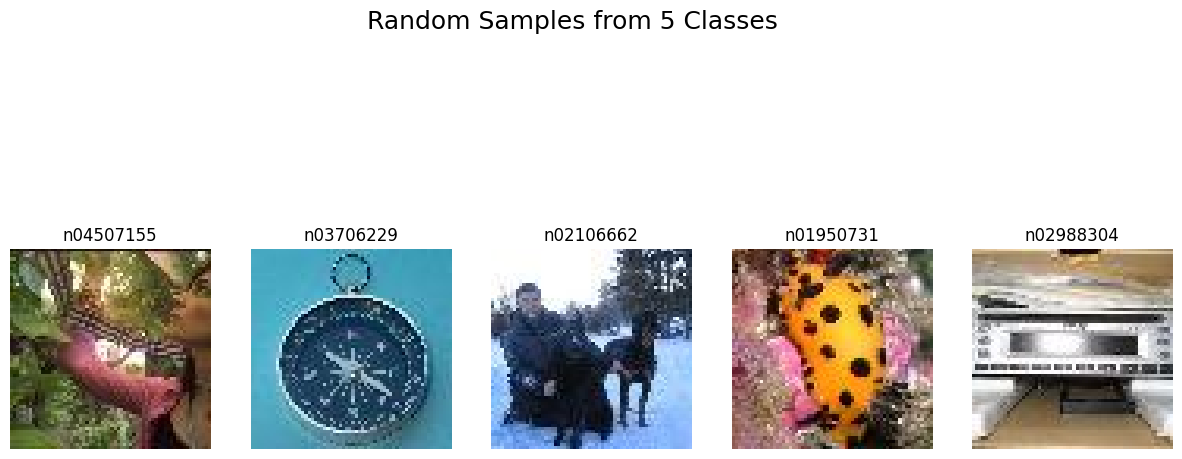

In [12]:
# === CELL: Visualize sample images ===
import matplotlib.pyplot as plt
import random
from PIL import Image

sample_classes = random.sample(sorted_classes, 5)

plt.figure(figsize=(15, 7))

for i, cls in enumerate(sample_classes):
    # pick random row from that class
    row = train_df[train_df["class"] == cls].sample(1).iloc[0]
    img_path = row["filepath"]

    img = Image.open(img_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Random Samples from 5 Classes", fontsize=18)
plt.show()


### Class Distribution (train) and written observations

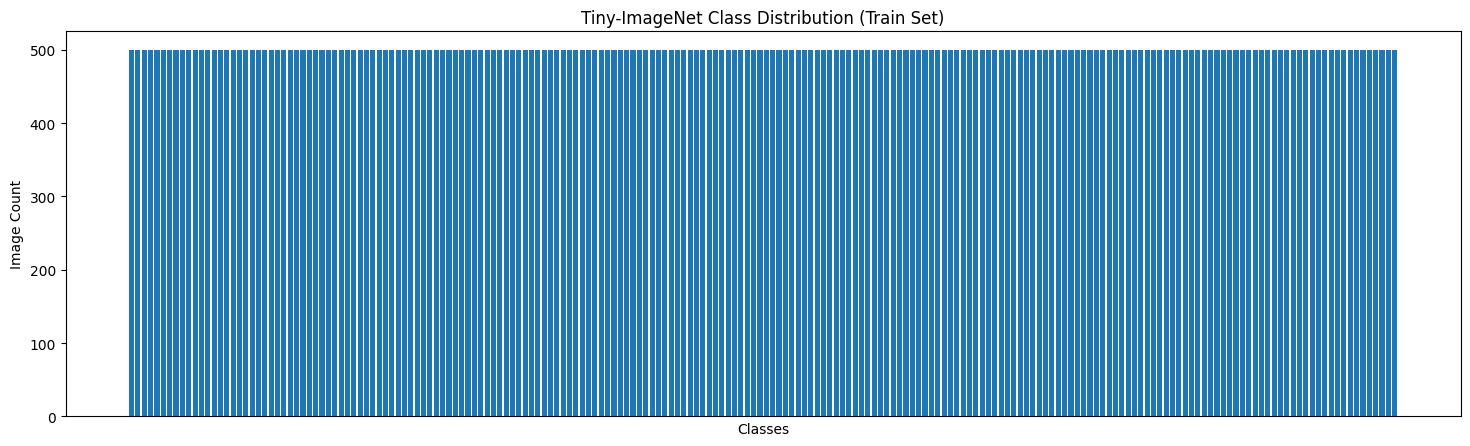

Summary:
 - Total classes: 200
 - Images per class (min, max): 500 500
 - Expected is exactly 500 per class.

Observations:
1. The dataset is perfectly balanced (500 images per class).
2. Images are low resolution (64x64), reducing fine-grained detail.
3. Some classes are visually similar (dogs, insects, vehicles) which increases confusion.
4. A few samples show lighting variation, blur, or noise.
5. Class overlap is possible because some categories differ by subtle shapes or textures.


In [13]:
# === Class distribution analysis ===
import matplotlib.pyplot as plt

class_counts = train_df["class"].value_counts().sort_index()

plt.figure(figsize=(18, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xticks([], [])  # hide class labels
plt.title("Tiny-ImageNet Class Distribution (Train Set)")
plt.xlabel("Classes")
plt.ylabel("Image Count")
plt.show()

print("Summary:")
print(" - Total classes:", len(class_counts))
print(" - Images per class (min, max):", class_counts.min(), class_counts.max())
print(" - Expected is exactly 500 per class.\n")

print("Observations:")
print("1. The dataset is perfectly balanced (500 images per class).")
print("2. Images are low resolution (64x64), reducing fine-grained detail.")
print("3. Some classes are visually similar (dogs, insects, vehicles) which increases confusion.")
print("4. A few samples show lighting variation, blur, or noise.")
print("5. Class overlap is possible because some categories differ by subtle shapes or textures.")


## Simple Custom CNN (5 Convolutional Blocks)

This model is intentionally kept simple to satisfy assignment requirements.  
Each block contains:

- 2× Conv2D layers  
- Batch Normalization after each convolution  
- ReLU activation  
- MaxPooling2D to downsample  

After 5 blocks, we flatten and use a Dense layer before the final 200-class softmax.  



In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_simple_cnn(input_shape=(64, 64, 3), num_classes=200):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Number of filters per block (scales by depth)
    filter_list = [32, 64, 128, 256, 256]

    for filters in filter_list:
        # Conv 1
        x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Conv 2
        x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Downsample
        x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)






### Compile the ResNet-18 Model  
We compile using Adam with a stable learning rate.  
Loss is categorical cross entropy because Tiny-ImageNet labels are one hot.  
Accuracy is tracked along with planned later metrics (Top 5 accuracy).


In [15]:
model = build_simple_cnn()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,864 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,864 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 11,281,032 (43.03 MB)

 Trainable params: 11,271,432 (43.00 MB)

 Non-trainable params: 9,600 (37.50 KB)

### Add Training Callbacks  
We include two callbacks to stabilize training:

1. **EarlyStopping**  
   Stops training when validation accuracy stops improving.  
   This prevents overfitting and wasted compute.

2. **ModelCheckpoint**  
   Saves the best performing model during training.  
   We will reload this model later for final evaluation.


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "best_resnet18.h5"

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False
    )
]

### Train the ResNet-18 Model  
We now begin full training using the GPU.  
The model will run for up to 20 epochs, but **EarlyStopping** may stop it earlier if validation accuracy plateaus.

Training includes:
- Feedforward and backprop on the training set  
- Validation tracking every epoch  
- Checkpoint saving for the best model  
- Early stopping to avoid overfitting


In [17]:
EPOCHS = 20  # GPU-friendly

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.0555 - loss: 4.7809 - top5_accuracy: 0.1715

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 192s 107ms/step - accuracy: 0.0556 - loss: 4.7807 - top5_accuracy: 0.1716 - val_accuracy: 0.0910 - val_loss: 4.7757 - val_top5_accuracy: 0.2561
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2023 - loss: 3.5137 - top5_accuracy: 0.4587

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.2023 - loss: 3.5136 - top5_accuracy: 0.4587 - val_accuracy: 0.1935 - val_loss: 3.7285 - val_top5_accuracy: 0.4371
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3092 - loss: 2.9281 - top5_accuracy: 0.5921

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accuracy: 0.3093 - loss: 2.9280 - top5_accuracy: 0.5922 - val_accuracy: 0.2951 - val_loss: 3.0864 - val_top5_accuracy: 0.5682
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3885 - loss: 2.5286 - top5_accuracy: 0.6724

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.3885 - loss: 2.5285 - top5_accuracy: 0.6724 - val_accuracy: 0.3494 - val_loss: 2.7815 - val_top5_accuracy: 0.6234
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4604 - loss: 2.1847 - top5_accuracy: 0.7388

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.4604 - loss: 2.1847 - top5_accuracy: 0.7388 - val_accuracy: 0.3688 - val_loss: 2.7208 - val_top5_accuracy: 0.6443
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5284 - loss: 1.8645 - top5_accuracy: 0.7938

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.5284 - loss: 1.8645 - top5_accuracy: 0.7938 - val_accuracy: 0.4291 - val_loss: 2.4428 - val_top5_accuracy: 0.6978
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5930 - loss: 1.5702 - top5_accuracy: 0.8409

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.5930 - loss: 1.5702 - top5_accuracy: 0.8409 - val_accuracy: 0.4373 - val_loss: 2.4340 - val_top5_accuracy: 0.7102
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.6691 - loss: 1.2525 - top5_accuracy: 0.8894 - val_accuracy: 0.4360 - val_loss: 2.5919 - val_top5_accuracy: 0.6941
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 96ms/step - accuracy: 0.7525 - loss: 0.9101 - top5_accuracy: 0.9355 - val_accuracy: 0.4268 - val_loss: 2.7461 - val_top5_accuracy: 0.6969
Epoch 10/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.8382 - loss: 0.5884 - top5_accuracy: 0.9710 - val_accuracy: 0.4203 - val_loss: 3.0644 - val_top5_accuracy: 0.6854


### Plot Training Curves  
To understand learning behavior, we plot both accuracy and loss for training and validation.  
This helps visualize:
- Whether the model is overfitting  
- Whether accuracy is improving across epochs  
- If loss is decreasing or plateauing  


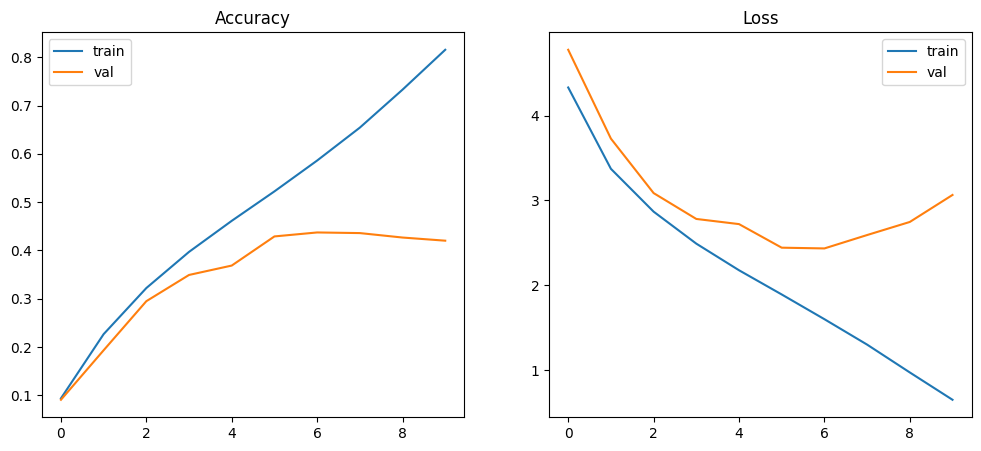

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss"); plt.legend()

plt.show()


### Collect Model Predictions for Confusion Matrix  
We gather predictions for the entire validation set by iterating over the validation generator.  
Steps:  
1. Reverse the `class_indices` mapping to convert integer predictions back to class names.  
2. Loop through all validation batches.  
3. Collect ground truth labels (`y_true`) and predicted labels (`y_pred`).  
4. Convert them to numpy arrays for confusion matrix computation.  


In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# You already have these
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Recreate the validation generator so it starts from the beginning
val_gen_iter = iter(val_generator)

y_true = []
y_pred = []

num_batches = len(val_generator)

for _ in range(num_batches):
    batch_x, batch_y = next(val_gen_iter)
    preds = model.predict(batch_x, verbose=0)

    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Prediction collection complete.")


Prediction collection complete.


### Confusion Matrix Visualization and Export  
To evaluate how well the model distinguishes between different categories, we compute the confusion matrix across all 200 classes.  
Since plotting all 200 categories at once becomes unreadable, we visualize only the first 20 classes as a heatmap.  

Steps:  
1. Compute the full confusion matrix using all validation predictions.  
2. Extract a smaller 20x20 subset for readable visualization.  
3. Plot a heatmap with seaborn.  
4. Save the full confusion matrix as a CSV file for further analysis or reporting.  


Confusion matrix shape: (200, 200)


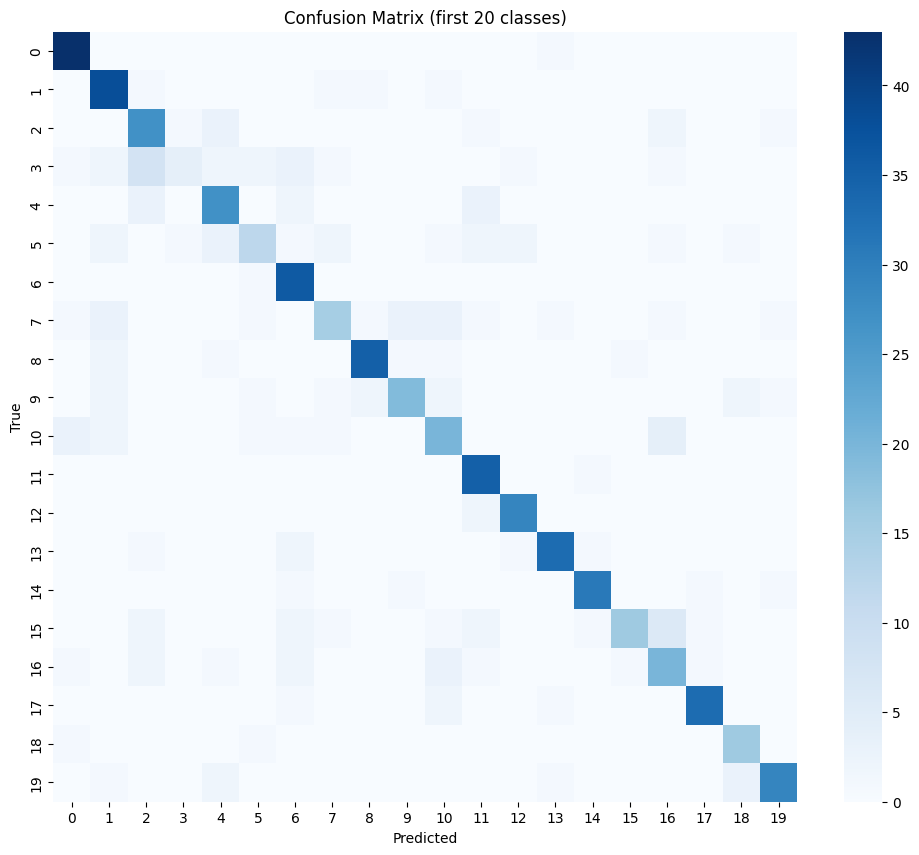

Confusion matrix saved to tiny_imagenet_confusion_matrix.csv


In [21]:
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

subset_classes = list(range(20))

cm_subset = cm[np.ix_(subset_classes, subset_classes)]

plt.figure(figsize=(12,10))
sns.heatmap(cm_subset, annot=False, cmap="Blues")
plt.title("Confusion Matrix (first 20 classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



df_cm = pd.DataFrame(cm)
df_cm.to_csv("tiny_imagenet_confusion_matrix.csv", index=False)
print("Confusion matrix saved to tiny_imagenet_confusion_matrix.csv")


### Evaluating the Best Saved Model  
After training with early stopping and checkpointing, the model with the highest validation accuracy is loaded from disk.  
To measure performance, we compute:  

- Final loss on the validation set  
- Top 1 accuracy  
- Top 5 accuracy  

Top 1 accuracy indicates whether the highest softmax probability matches the true class.  
Top 5 accuracy checks whether the correct label appears within the five most likely predictions.  


In [22]:
best_model = tf.keras.models.load_model("best_resnet18.h5")

results = best_model.evaluate(val_generator)
print("Best model results:", results)
print("Top 1 accuracy:", results[1])
print("Top 5 accuracy:", results[2])


156/156 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.4368 - loss: 2.4211 - top5_accuracy: 0.7162
Best model results: [2.4340243339538574, 0.4372996687889099, 0.7102363705635071]
Top 1 accuracy: 0.4372996687889099
Top 5 accuracy: 0.7102363705635071
